# Batch Effect Analsis Galapagos radiation dataset

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm.autonotebook import tqdm as tqdm
import csv
import os

/tmp/user/20166/ipykernel_729962/1139393030.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as tqdm


In [2]:
def check_if_nan(value):
    """return Boolean version of value that is True if value is
    some type of NaN (e.g. np.nan, None, "nan" etc). 
    Example use:
    none_entries = subadata.obs.applymap(check_if_nan)
    subadata.obs = subadata.obs.mask(none_entries.values)
    """
    if value == "nan":
        return True
    elif value == None:
        return True
    if isinstance(value, float):
        if np.isnan(value):
            return True
    if value == "ND":
        return True
    return False

## Set paths 

In [3]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/adata_radiation_processed.h5ad"
# path to results directory:
dir_out = "/home/h/hollenberg/MaPra/"

In [4]:
adata = sc.read(adata_path)

In [5]:
adata.obs = pd.read_csv(os.path.join(dir_out, 'radiation_obs_annotation.csv'))

## Set Covariates

specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [6]:
covariates = [
    "Phase", 
    "tube_ID", 
    "SAMP_ID",
    "SAMP_condition",
    "SAMP_stage",
    "SAMP_exp_group",
    "SC_prep", 
    "annotation"
]

Create shuffled assignment of single cell platform (and processing site if included), to compare actual variance explained to variance explained expected by random. We will assign all cells of the same sample to the same value.

In [7]:
# create shuffled version of single cell platform, and of Processing_site:
sample_to_covariate = pd.DataFrame()
covariates_to_shuffle = [
    "Phase", 
    #"tube_ID", 
    "SAMP_ID",
    "SAMP_condition",
    "SAMP_stage",
    "SAMP_exp_group",
    "SC_prep", 
    "annotation"
]

for group in covariates_to_shuffle:
    sample_to_covariate[group] = adata.obs.groupby("tube_ID").agg({group: "first"})
    
    for i in range(10):
        np.random.shuffle(sample_to_covariate[group])
        adata.obs["shuffled_"+ group + str(i)] = adata.obs["tube_ID"].map(
            dict(
                zip(
                    sample_to_covariate.index,
                    sample_to_covariate[group],
                )
            )
        )
        covariates.append("shuffled_"+ group + str(i))

print(covariates)
sample_to_covariate

/tmp/user/20166/ipykernel_729962/470139869.py:18: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/user/20166/ipykernel_729962/470139869.py:18: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/user/20166/ipykernel_729962/470139869.py:18: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp

['Phase', 'tube_ID', 'SAMP_ID', 'SAMP_condition', 'SAMP_stage', 'SAMP_exp_group', 'SC_prep', 'annotation', 'shuffled_Phase0', 'shuffled_Phase1', 'shuffled_Phase2', 'shuffled_Phase3', 'shuffled_Phase4', 'shuffled_Phase5', 'shuffled_Phase6', 'shuffled_Phase7', 'shuffled_Phase8', 'shuffled_Phase9', 'shuffled_SAMP_ID0', 'shuffled_SAMP_ID1', 'shuffled_SAMP_ID2', 'shuffled_SAMP_ID3', 'shuffled_SAMP_ID4', 'shuffled_SAMP_ID5', 'shuffled_SAMP_ID6', 'shuffled_SAMP_ID7', 'shuffled_SAMP_ID8', 'shuffled_SAMP_ID9', 'shuffled_SAMP_condition0', 'shuffled_SAMP_condition1', 'shuffled_SAMP_condition2', 'shuffled_SAMP_condition3', 'shuffled_SAMP_condition4', 'shuffled_SAMP_condition5', 'shuffled_SAMP_condition6', 'shuffled_SAMP_condition7', 'shuffled_SAMP_condition8', 'shuffled_SAMP_condition9', 'shuffled_SAMP_stage0', 'shuffled_SAMP_stage1', 'shuffled_SAMP_stage2', 'shuffled_SAMP_stage3', 'shuffled_SAMP_stage4', 'shuffled_SAMP_stage5', 'shuffled_SAMP_stage6', 'shuffled_SAMP_stage7', 'shuffled_SAMP_stage8

/tmp/user/20166/ipykernel_729962/470139869.py:18: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])
/tmp/user/20166/ipykernel_729962/470139869.py:18: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_covariate[group])


,Phase,SAMP_ID,SAMP_condition,SAMP_stage,SAMP_exp_group,SC_prep,annotation
tube_ID,,,,,,,
RADsc_A1,G1,55_Sham19w,SHAM,16weeks,RAD_13weeks,day1_group2,Endothelial
RADsc_A2,G1,62_RAD19w,RAD,19weeks,RAD_16weeks,day2_group4,B-cells
RADsc_A3,G2M,71_RAD19w,RAD,13weeks,SHAM_19weeks,day1_group3,Myofibroblasts
RADsc_A4,G1,72_RAD19w,RAD,19weeks,SHAM_13weeks,day3_group9,Dendritic cells
RADsc_A5,S,20_RAD13w,SHAM,19weeks,RAD_19weeks,day1_group1,Myofibroblasts
...,...,...,...,...,...,...,...
RADsc_H5,S,34_Sham16w,SHAM,16weeks,RAD_13weeks,day3_group8,B-cells
RADsc_H6,G1,70_RAD19w,SHAM,19weeks,SHAM_16weeks,day2_group5,Monocytes
RADsc_H7,G1,74_RAD19w,RAD,19weeks,RAD_19weeks,day3_group8,T-cells


## 50 PCs

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [8]:
n_pcs = 50

In [9]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in tqdm(range(n_pcs)):
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

100%|███████████████████████████████████████████| 50/50 [40:42<00:00, 48.85s/it]


## Visualize Effects 

In [10]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("shuffled_")
    ]
]
total_variance_explained_clean = total_variance_explained_clean[1:]
total_variance_explained_clean

annotation        0.742716
Phase             0.050914
SAMP_ID           0.040047
tube_ID           0.040015
SAMP_exp_group    0.020384
SAMP_condition    0.012844
SC_prep            0.01012
SAMP_stage        0.005889
dtype: object

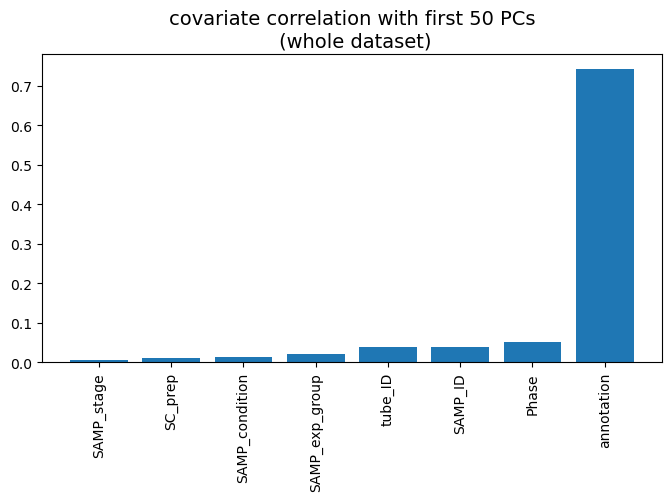

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
) 
plt.xticks(rotation=90)
plt.show()

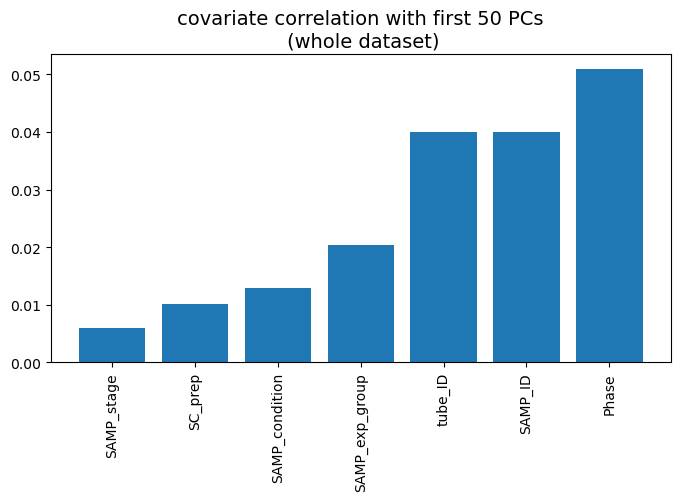

In [15]:
total_variance_explained_without_ann = total_variance_explained_clean[1:]

plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_without_ann[::-1].index,
    total_variance_explained_without_ann[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
) 
plt.xticks(rotation=90)
plt.show()

## Compare the effects with the effects visible in a shuffled annotation¶

In [19]:
groups = [
    "Phase", 
    #"tube_ID", 
    "SAMP_ID",
    "SAMP_condition",
    "SAMP_stage",
    "SAMP_exp_group",
    "SC_prep", 
    "annotation"
]

stdev_single_cell_platform_shuffled = {}
for group in groups:
    total_variance_explained_clean[f"shuffled_{group}"] = np.mean(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
    stdev_single_cell_platform_shuffled[f"shuffled_{group}"] = np.std(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith(f"shuffled_{group}")
            ]
        ]
    )
    
stdev_single_cell_platform_shuffled

{'shuffled_Phase': 0.0006128884278341616,
 'shuffled_SAMP_condition': 0.00022225751305962537,
 'shuffled_SAMP_stage': 0.00026411497314901284,
 'shuffled_SAMP_exp_group': 0.0007860005624111162,
 'shuffled_SC_prep': 0.0012530946817723902,
 'shuffled_annotation': 0.0008153680896729474}

In [22]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)
total_variance_explained_clean

annotation                 0.742716
Phase                      0.050914
SAMP_ID                    0.040047
tube_ID                    0.040015
shuffled_SAMP_ID           0.040013
SAMP_exp_group             0.020384
SAMP_condition             0.012844
SC_prep                     0.01012
shuffled_annotation        0.006765
SAMP_stage                 0.005889
shuffled_SC_prep            0.00502
shuffled_SAMP_exp_group    0.002807
shuffled_Phase             0.001261
shuffled_SAMP_stage        0.000936
shuffled_SAMP_condition    0.000408
dtype: object

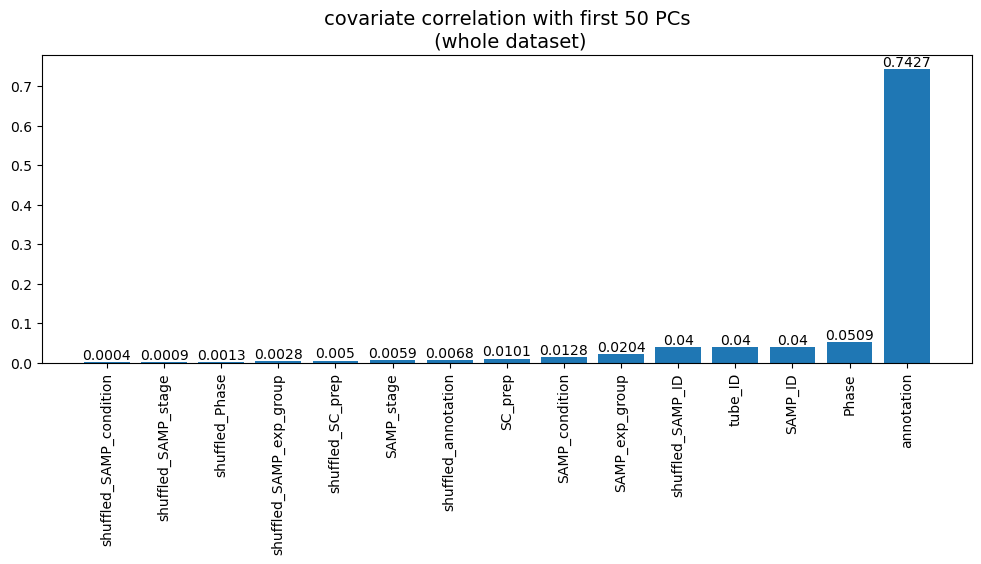

In [24]:
plt.figure(figsize=(12, 4))
rounded_values = total_variance_explained_clean[::-1].values.astype('float').round(4)
plt.bar(
    total_variance_explained_clean[::-1].index,
    rounded_values,
)

# Add rounded numbers on top of the bars
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)
plt.xticks(rotation=90)
plt.show()


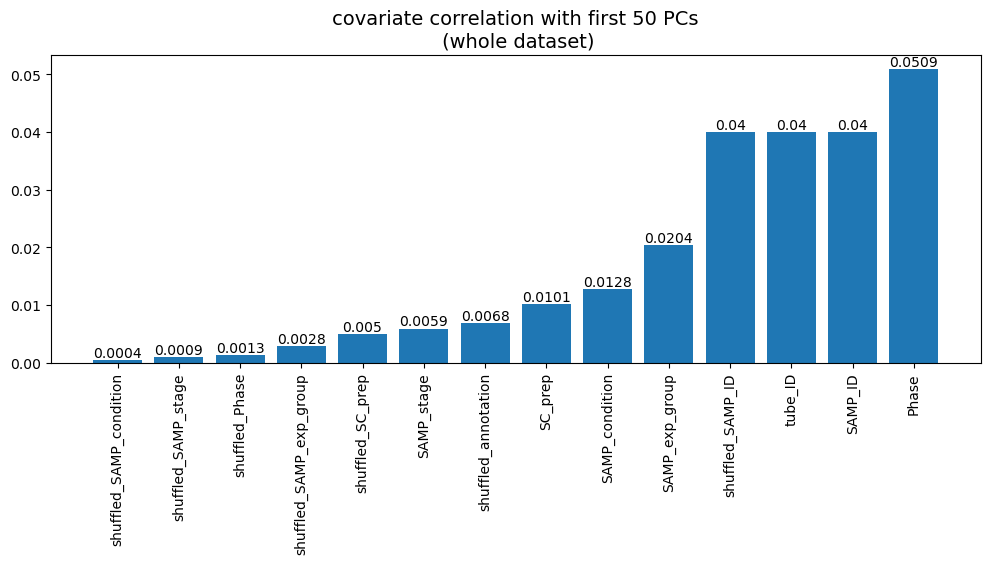

In [25]:
total_variance_explained_clean_ohne_ann = total_variance_explained_clean[1:]
plt.figure(figsize=(12, 4))
rounded_values = total_variance_explained_clean_ohne_ann[::-1].values.astype('float').round(4)
plt.bar(
    total_variance_explained_clean_ohne_ann[::-1].index,
    rounded_values,
)

# Add rounded numbers on top of the bars
for i, value in enumerate(rounded_values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)
plt.xticks(rotation=90)
plt.show()


## Store results 

In [26]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]
for group in groups:
    res.loc[f"shuffled_{group}", "stdev"] = stdev_single_cell_platform_shuffled[f"shuffled_{group}"]

res

,fraction_of_variance_explained,stdev
annotation,0.742716,NaN
Phase,0.050914,NaN
SAMP_ID,0.040047,NaN
tube_ID,0.040015,NaN
shuffled_SAMP_ID,0.040013,NaN
SAMP_exp_group,0.020384,NaN
SAMP_condition,0.012844,NaN
SC_prep,0.01012,NaN
shuffled_annotation,0.006765,0.000815
SAMP_stage,0.005889,NaN


In [27]:
res.to_csv(
    f"{dir_out}/galapagos_radiation_variance_explained_per_covariate.csv"
)

In [28]:
for group in groups:
    print(group)
    print(
        (res.loc[group, "fraction_of_variance_explained"]
        - res.loc[f"shuffled_{group}", "fraction_of_variance_explained"]
        ) / res.loc[f"shuffled_{group}", "stdev"]

    )

Phase
81.01444390602845
SAMP_condition
55.954875253262
SAMP_stage
18.750508409116758
SAMP_exp_group
22.363225517277105
SC_prep
4.0700450301555895
annotation
902.5996709003622


In [51]:
# final plot for the report 
df = pd.read_csv(f"{dir_out}/galapagos_radiation_variance_explained_per_covariate.csv")
df.rename(columns={'Unnamed: 0': 'groupings'}, inplace=True)

sorted = ['Phase', 'shuffled_Phase', 'SAMP_ID', "shuffled_SAMP_ID", 'tube_ID', 
          'SAMP_exp_group', 'shuffled_SAMP_exp_group', 'SAMP_condition', "shuffled_SAMP_condition",
         'SC_prep', 'shuffled_SC_prep', 'SAMP_stage', 'shuffled_SAMP_stage' ]
sorted = reversed(sorted)

df['groupings'] = pd.Categorical(df['groupings'], categories=sorted, ordered=True)
df_sorted = df.sort_values('groupings')[0:13]

#print(df_sorted)

filtered = df_sorted[df_sorted.groupings != "shuffled_SAMP_ID"]
filtered

                  groupings  fraction_of_variance_explained     stdev
13      shuffled_SAMP_stage                        0.000936  0.000264
9                SAMP_stage                        0.005889       NaN
10         shuffled_SC_prep                        0.005020  0.001253
7                   SC_prep                        0.010120       NaN
14  shuffled_SAMP_condition                        0.000408  0.000222
6            SAMP_condition                        0.012844       NaN
11  shuffled_SAMP_exp_group                        0.002807  0.000786
5            SAMP_exp_group                        0.020384       NaN
3                   tube_ID                        0.040015       NaN
4          shuffled_SAMP_ID                        0.040013       NaN
2                   SAMP_ID                        0.040047       NaN
12           shuffled_Phase                        0.001261  0.000613
1                     Phase                        0.050914       NaN


,groupings,fraction_of_variance_explained,stdev
13,shuffled_SAMP_stage,0.000936,0.000264
9,SAMP_stage,0.005889,NaN
10,shuffled_SC_prep,0.005020,0.001253
7,SC_prep,0.010120,NaN
14,shuffled_SAMP_condition,0.000408,0.000222
6,SAMP_condition,0.012844,NaN
11,shuffled_SAMP_exp_group,0.002807,0.000786
5,SAMP_exp_group,0.020384,NaN
3,tube_ID,0.040015,NaN
2,SAMP_ID,0.040047,NaN


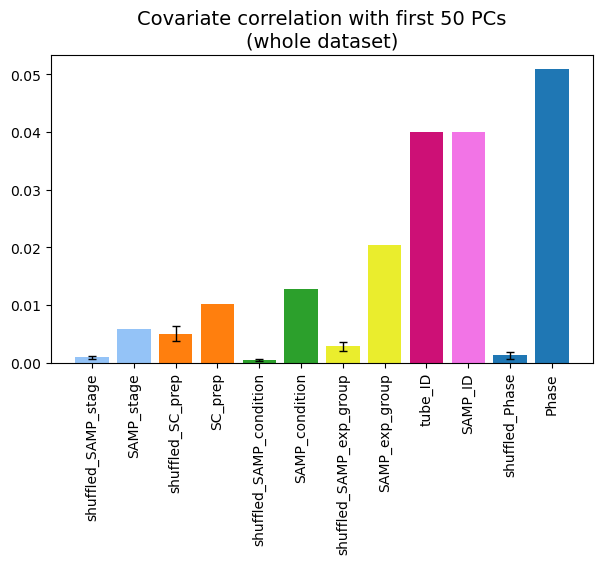

In [52]:
# Colors for the bars
colors = ['#94c3f7', '#94c3f7', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c', 
         '#eaed2d', '#eaed2d','#CD1076', '#f274e6', '#1f77b4', '#1f77b4']
# Plot
plt.figure(figsize=(7, 4))
rounded_values = filtered["fraction_of_variance_explained"]
x_values = np.arange(len(rounded_values))

# Draw bars and assign colors
plt.bar(x_values, rounded_values, color=colors)

# Add error bars
plt.errorbar(x_values, rounded_values, yerr=filtered["stdev"], fmt='none', ecolor='black', elinewidth=1, capsize=3)

plt.title("Covariate correlation with first 50 PCs\n(whole dataset)", fontsize=14)
plt.xticks(x_values, filtered["groupings"], rotation=90)
plt.show()